In [21]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../data')
from data_loading import *

from Model import *

fname = "../data/up_down/100GEV-downquark-seed1.txt"

jets = jets_from_pythia_txt(fname)
print("Number of jets in file: ", len(jets))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of jets in file:  10000


[23 23 16 22 21 14 16 16 14 18 13 17 15 14 16 16 16 15 16 15 16 15]


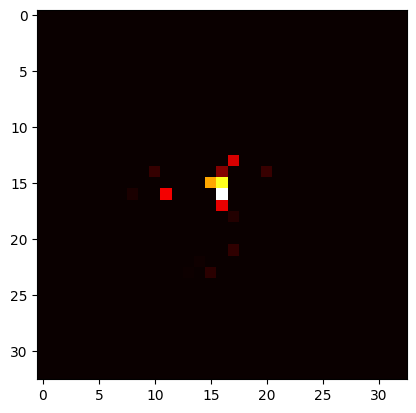

In [44]:
from JetImages import JetImage

image = JetImage(jets[0])

kappa = 0.2
ch2 = image.create_image(kappa)[0, :, :]

import matplotlib.pyplot as plt
plt.imshow(ch2, cmap='hot', interpolation='nearest')